# Scalable Social Network Analysis

In [1]:
#imports
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import random

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)

from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import colorlover as cl
from IPython.display import HTML

In [840]:
df = pd.read_csv("tweets2009-06-0115.csv", sep='\t')

In [856]:
hashTag = df[df["tweet"].str.lower().str.contains("#swineflu", na=False)].copy()

In [857]:
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows
hashTag.head()

,date,user,tweet
788,2009-06-11 16:57:58,vaagogo,#swineflu found this great report about pregnancy health and swineflu - it is a must read http://budurl.com/DrZswineflu
8119,2009-06-11 17:10:47,1nerdgirl,This is getting a little scary.. World Health Organization has declared a pandemic of H1N1 flu. Now Phase 6 http://bit.ly/jhXkf #swineflu
11993,2009-06-11 17:14:20,h1n1swineflu,#swineflu WHO declares swine flu pandemic: Drug companies have told WHO that production of seasonal flu.. http://tinyurl.com/n6h6gu
12295,2009-06-11 17:14:55,rssmicro,Swine Flu - Recent News: http://www.rssmicro.com/search/Swine-Flu #swineflu
17153,2009-06-11 17:21:38,swineflumaps,I've included hyperlinks to data sources in my spreadsheet http://tinyurl.com/cgoc47 #swineflu #h1n1: I've inclu.. http://tinyurl.com/mntfgp


In [858]:
hashTag.to_csv('swineflu.csv')

In [859]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [860]:
addMentionedColumn(hashTag)

In [861]:
hashTag.head()

,date,user,tweet,mentioned
788,2009-06-11 16:57:58,vaagogo,#swineflu found this great report about pregnancy health and swineflu - it is a must read http://budurl.com/DrZswineflu,[]
8119,2009-06-11 17:10:47,1nerdgirl,This is getting a little scary.. World Health Organization has declared a pandemic of H1N1 flu. Now Phase 6 http://bit.ly/jhXkf #swineflu,[]
11993,2009-06-11 17:14:20,h1n1swineflu,#swineflu WHO declares swine flu pandemic: Drug companies have told WHO that production of seasonal flu.. http://tinyurl.com/n6h6gu,[]
12295,2009-06-11 17:14:55,rssmicro,Swine Flu - Recent News: http://www.rssmicro.com/search/Swine-Flu #swineflu,[]
17153,2009-06-11 17:21:38,swineflumaps,I've included hyperlinks to data sources in my spreadsheet http://tinyurl.com/cgoc47 #swineflu #h1n1: I've inclu.. http://tinyurl.com/mntfgp,[]


## Q2. Mention Graph

In [862]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, {'numberMentions': 1})
    
    return g

In [863]:
hashtagGraph = mentionGraph(hashTag)

## a)

In [864]:
print("# nodes:", len(hashtagGraph.nodes()))
print("# edges:", len(hashtagGraph.edges()))

# nodes: 175
# edges: 128


## b)

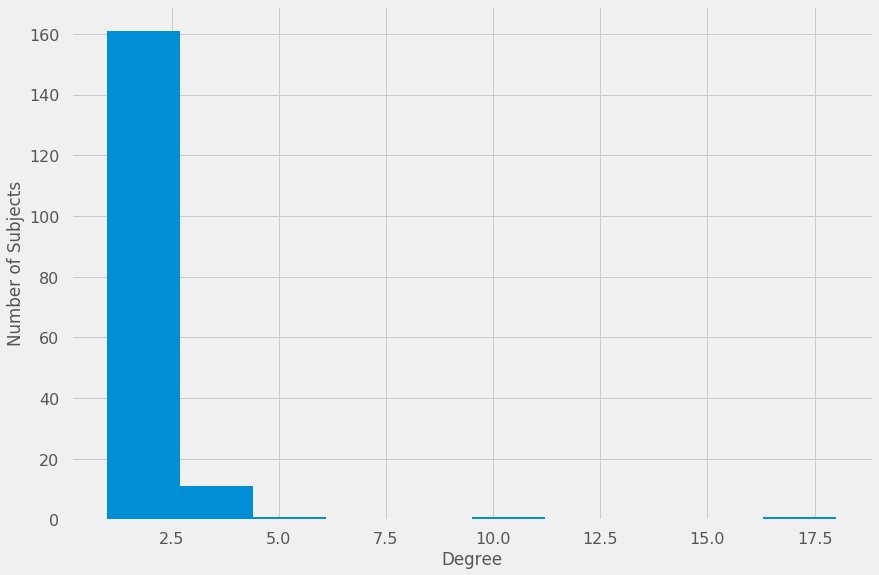

In [865]:
plt.hist(list(nx.degree(hashtagGraph).values()))
plt.style.use('fivethirtyeight')
plt.xlabel('Degree')
plt.ylabel('Number of Subjects')
plt.show()
#plt.savefig('network_degree.png') #Save as file, format specified in argument

## c)

In [866]:
edges = hashtagGraph.edges(data = True)
edges[0:5]

[('mrsflinger', 'jennyonthespot', {'numberMentions': 1}),
 ('kasshout', 'instedd_evolve', {'numberMentions': 1}),
 ('workecology', 'dkmatai', {'numberMentions': 1}),
 ('hisra', 'el_universal_mx)', {'numberMentions': 1}),
 ('ijeffry', 'h1n1info', {'numberMentions': 1})]

In [867]:
edgesDf = pd.DataFrame(edges, columns=['node 1', 'node 2','numberMentions'])
edgesDf = pd.concat([edgesDf.drop(['numberMentions'], axis=1), edgesDf['numberMentions'].apply(pd.Series)], axis=1)
edgesDf.sort_values('numberMentions', ascending=False).head()

,node 1,node 2,numberMentions
18,swineflumaps,sophie_gill,4
75,ecoworrier,ecoworrier,4
72,standingfirmcm,fla_medic,3
23,swineflumaps,ecoworrier,3
13,preachgold,preachgold,2


## d)

In [889]:
# Add Top-K words for every user
tDf = hashTag.drop(['date', 'mentioned'], axis=1)
userTweetDf = tDf.groupby(['user'])['tweet'].apply(','.join).reset_index()
my_list = userTweetDf["user"].tolist()
noTweets = 'No Tweets Found'

def topWordsUser(user):
    
    if user in my_list:
        tweet = str(userTweetDf.loc[userTweetDf['user'] == user]['tweet'].values)
        tweetWords1 = [word.strip("""-,.:()'\!/"; """).lower() for word in tweet.split()]
        hashTags1 = [word for word in tweetWords1 if word not in stop and not word.startswith("#") and word.isalnum()]
        hashTagsCounter1 = Counter(hashTags1)
        top3 = hashTagsCounter1.most_common(3)
        return top3
    else:
        return noTweets

In [869]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph,"pos", posDict)

In [870]:
addRandomPositions(hashtagGraph)

In [871]:
purd = cl.scales['9']['seq']['Blues']
purd300 = cl.interp(purd, 70)
HTML(cl.to_html(purd300))

In [890]:
def plotNetwork(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgeColor = int(24 + (edgeWidth**2.7))
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines',
                line=Line(width=edgeWidth , color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\n %s" % (node, topWordsUser(node)),
                hoverinfo='text',
                mode='marker', 
                marker=dict(
                    color="#888", 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [891]:
plotNetwork(hashtagGraph)

In [638]:
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, "pos", posDict)

In [639]:
hashtagGraphSpring = hashtagGraph.copy()
applyLayout(hashtagGraphSpring, nx.spring_layout)
plotNetwork(hashtagGraphSpring)

In [643]:
hashtagGraphCircular = hashtagGraph.copy()
applyLayout(hashtagGraphCircular, nx.circular_layout)
plotNetwork(hashtagGraphCircular)

## Q3. Content Analysis

## a)

In [700]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
stop = set(stopwords.words('english'))
stop.add('rt')

allTweets = hashTag["tweet"].str.cat(sep=' ')
tweetWords = [word.strip("""-,.:()'\!/"; """).lower() for word in allTweets.split()]
hashTags = [word for word in tweetWords if word not in stop and not word.startswith("#") and word.isalnum()]
hashTagsCounter = Counter(hashTags)

In [706]:
hashTagsCounter.most_common(25)

[('flu', 261),
 ('swine', 204),
 ('pandemic', 81),
 ('h1n1', 77),
 ('cases', 68),
 ('vaccine', 33),
 ('new', 32),
 ('first', 25),
 ('declares', 22),
 ('health', 21),
 ('virus', 20),
 ('death', 19),
 ('update', 19),
 ('via', 16),
 ('post', 16),
 ('news', 15),
 ('global', 15),
 ('press', 15),
 ('june', 14),
 ('influenza', 14),
 ('plz', 14),
 ('deaths', 14),
 ('2009', 13),
 ('get', 13),
 ('cdc', 13)]

#### General Themes (Top Most Common Words Bolded)
- The hashtag #swineflu refers to the **2009** **flu** **pandemic** (https://en.wikipedia.org/wiki/2009_flu_pandemic), commonly known as the **swine** flu.
- Influenza strain **h1n1**
- 50 000+ confirmed **cases** in the US, 5,000+ confirmed cases in Canada
- **vaccines** were developed to help protect against the **virus**
- Multiple **deaths**


## b)

In [892]:
plotNetwork(hashtagGraph)

## Q4. Centrality Analysis

## a)

In [640]:
nx.degree_centrality(hashtagGraph)

{'': 0.005747126436781609,
 '612brisbane': 0.005747126436781609,
 'aaronbassett': 0.005747126436781609,
 'adrian67': 0.005747126436781609,
 'alainochoa': 0.005747126436781609,
 'alexwoodcreates': 0.005747126436781609,
 'andewpwilson': 0.005747126436781609,
 'anteek': 0.005747126436781609,
 'asteris': 0.005747126436781609,
 'astradaemon': 0.011494252873563218,
 'aus_pol': 0.005747126436781609,
 'babysherlene': 0.005747126436781609,
 'bbc_haveyoursay': 0.005747126436781609,
 'bbc_whys': 0.005747126436781609,
 'blacksoultan': 0.005747126436781609,
 'blacksoultan)': 0.005747126436781609,
 'bloggi': 0.011494252873563218,
 'brodyharper': 0.005747126436781609,
 'brucemills': 0.005747126436781609,
 'cdcemergency': 0.017241379310344827,
 'cdcflu': 0.05747126436781609,
 'checkers': 0.005747126436781609,
 'chirplouder': 0.011494252873563218,
 'cinnamon_chanel': 0.005747126436781609,
 'clinica': 0.005747126436781609,
 'cockyraces': 0.005747126436781609,
 'colgo': 0.011494252873563218,
 'coxymoney'

In [920]:
nx.betweenness_centrality(hashtagGraph)

{'': 0.0,
 '612brisbane': 0.0,
 'aaronbassett': 0.0,
 'adrian67': 0.0,
 'alainochoa': 0.0,
 'alexwoodcreates': 0.0,
 'andewpwilson': 0.0,
 'anteek': 0.0,
 'asteris': 0.0,
 'astradaemon': 0.0006644076805527872,
 'aus_pol': 0.0,
 'babysherlene': 0.0,
 'bbc_haveyoursay': 0.0,
 'bbc_whys': 0.0,
 'blacksoultan': 0.0,
 'blacksoultan)': 0.0,
 'bloggi': 6.644076805527871e-05,
 'brodyharper': 0.0,
 'brucemills': 0.0,
 'cdcemergency': 0.0008305096006909839,
 'cdcflu': 0.0047505149159524284,
 'checkers': 0.0,
 'chirplouder': 0.008570859079130954,
 'cinnamon_chanel': 0.0,
 'clinica': 0.0,
 'cockyraces': 0.0,
 'colgo': 6.644076805527871e-05,
 'coxymoney': 0.0,
 'cp_branswell': 0.016277988173543284,
 'cynicor': 0.0,
 'daniel_sellers': 0.0,
 'danielooi': 0.0,
 'dannunan': 0.0,
 'darkuga': 6.644076805527871e-05,
 'dkellis': 0.0,
 'dkmatai': 0.0,
 'donnasworld1': 0.0,
 'earleyedition': 0.0,
 'ecoworrier': 0.0,
 'ehandersonpr': 0.0,
 'el_universal_mx)': 0.0,
 'elviraafterall': 0.0,
 'englishchick': 0.00

In [900]:
purdc = cl.scales['9']['seq']['PuRd']
purdc300 = cl.interp(purdc, 300)
HTML(cl.to_html(purdc300))

In [903]:
def plotNetworkCenterColor(graph, centrality):
    
    if centrality == 'degree':
        closenessCentr = nx.degree_centrality(hashtagGraph)
        measure = 'degree'
    elif centrality == 'betweenness':
        closenessCentr = nx.betweenness_centrality(hashtagGraph)
        measure = 'betweenness'
    else:
        error = 'Incorrect centrality value given.'
        return error

    maxCentr = max(closenessCentr.values())
    minCentr = min(closenessCentr.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgeColor = edgeWidth
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = closenessCentr[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\n %s\n: %.3f" % (node, measure, nodeCentr),
                hoverinfo='text',
                mode='marker', 
                marker=dict(
                    color=purdc300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [904]:
plotNetworkCenterColor(hashtagGraph, 'degree')

In [905]:
plotNetworkCenterColor(hashtagGraph, 'betweenness')

### Spring Layout

In [927]:
hashtagGraphSpring = hashtagGraph.copy()
applyLayout(hashtagGraphSpring, nx.spring_layout)
plotNetworkCenterColor(hashtagGraphSpring, 'degree')

In [928]:
hashtagGraphSpring = hashtagGraph.copy()
applyLayout(hashtagGraphSpring, nx.spring_layout)
plotNetworkCenterColor(hashtagGraphSpring, 'betweenness')

## d)

In [925]:
dc = nx.degree_centrality(hashtagGraph)
degreeCent = pd.DataFrame(list(dc.items()), columns=['Node', 'Degree Centrality'])
degreeCent.sort_values('Degree Centrality', ascending=False).head(10)

,Node,Degree Centrality
28,swineflumaps,0.103448
63,cdcflu,0.057471
98,peterosbornuk,0.028736
58,jayshep,0.022989
55,lyne_robichaud,0.022989
133,laibcoms,0.017241
17,sunjournal,0.017241
156,kelake,0.017241
22,preachgold,0.017241
124,warkoholic,0.017241


In [929]:
cb = nx.betweenness_centrality(hashtagGraph)
betweenCent = pd.DataFrame(list(cb.items()), columns=['Node', 'Betweenness'])
betweenCent.sort_values('Betweenness', ascending=False).head(10)

,Node,Betweenness
28,swineflumaps,0.061657
98,peterosbornuk,0.020995
75,cp_branswell,0.016278
55,lyne_robichaud,0.011494
133,laibcoms,0.010033
58,jayshep,0.008770
99,chirplouder,0.008571
122,swinefluupdate,0.005847
100,fla_medic,0.005847
134,healthylifetwit,0.005515


- The results are somewhat simmilar (swineflumaps, peterosbornuk, lyne_robichaud, laibcoms) but not the same. 
    - Degree centrality refers to the number of ties a node has to other nodes. 
    - Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
- Reason for difference: Users with most connections arent necesarily the ones connecting two groups/acting as bridges (belong more to ingroup vs outgroup).
- In this case degree centrality produced a more meaningful interpretation. Though simple, degree is often a highly effective measure of the influence or importance of a node. For example, in many social settings such as twitter people with more connections tend to have more power and more visible.
<br>
<br>
Source:http://www2.unb.ca/~ddu/6634/Lecture_notes/Lecture_4_centrality_measure.pdf


## Q5. Connectivity Patterns 

## a)

In [964]:
numCliques = list(nx.find_cliques(hashtagGraph))

print("# of maximal cliques :", nx.graph_number_of_cliques(hashtagGraph, numCliques))

# of maximal cliques : 124


In [952]:
print("Graph’s clique number :", nx.graph_clique_number(hashtagGraph))

Graph’s clique number : 3


In [967]:
print("Number of maximal cliques for each node :")
numMaxC = nx.number_of_cliques(hashtagGraph)
numMaxCDf = pd.DataFrame(list(numMaxC.items()), columns=['Node', 'Maximum Cliques'])
numMaxCDf.sort_values('Maximum Cliques', ascending=False).head(15)

Number of maximal cliques for each node :


,Node,Maximum Cliques
28,swineflumaps,18
63,cdcflu,10
98,peterosbornuk,5
55,lyne_robichaud,4
58,jayshep,4
104,cdcemergency,3
124,warkoholic,3
156,kelake,3
17,sunjournal,3
75,cp_branswell,3


In [968]:
print("Size of the largest maximal clique containing each given node:")
maxClique = nx.node_clique_number(hashtagGraph)
maxCliqueDf = pd.DataFrame(list(maxClique.items()), columns=['Node', 'Size'])
maxCliqueDf.sort_values('Size', ascending=False).head(15)

Size of the largest maximal clique containing each given node:


,Node,Size
174,hollingsworth,3
173,ozdj,3
172,fridley,3
118,tenspider,2
110,profvrr:basic,2
111,thetj00,2
112,soonersherm,2
113,alexwoodcreates,2
114,clinica,2
115,twellness,2


## b)

- A clique is defined as a maximal complete subgraph of a given graph—i.e., a group of people where everybody is connected directly to everyone else.
- The graph is comprised of 124 cliques, while the graphs clique number is 3, which means the largest number of interconnected users here is 3. Therefore, users mostly haven't tweeted at each other. All other users are in a clique size of 2. 
- swineflumaps (18), cdcflu (10), peterosbohernuk (5) are the users (nodes) in the most number of cliques
- fridley , ozdj, hollingsworth are the users in the largest clique of size (3)